In [1]:
import aomip
import numpy as np
import json
from os.path import join
from tifffile import imsave, imread
from scipy.io import loadmat
import matplotlib.pyplot as plt
from preprocessing import bin_array
import GradientDescent
from utils import save_array_as_image
from challenge import utils
from scipy.sparse import diags,spdiags

pyelsa not build with CUDA projector support


In [2]:
with open("config.json", "r") as json_data_file:
    data = json.load(json_data_file)
dataset = data["htc"]
data_path = (dataset["data_path"])["local"]
file_name = dataset["phantom1b"]

mat = loadmat(join(data_path,file_name))
data = mat['CtDataFull']
fullsino=data[0][0][1]
sino = bin_array(fullsino,2)
b=sino.flatten()
#b=fullsino.flatten()

size = np.array([512, 512])

num_angles = 360 #721
arc = 360

s2c = size[0] * 20
c2d = size[0] * 0.1
D = s2c + c2d
A = aomip.XrayOperator(size, [num_angles], np.linspace(0, arc, 280), s2c, c2d)

###################### Filter ##############################################
H = np.linspace(-1, 1, sino.shape[0])

ram_lak = np.abs(H)
shepp_logan = np.abs(H) * np.sinc(H / 2)
cosine = np.abs(H) * np.cos(H * np.pi / 2)

h = np.tile(shepp_logan, (280, 1)).T
fftsino = np.fft.fft(sino, axis=0)
projection = np.fft.fftshift(fftsino, axes=1) * np.fft.fftshift(h, axes=0)
fsino = np.real(np.fft.ifft(np.fft.ifftshift(projection, axes=1), axis=0))
###################### Filter ##############################################

fbp_recon = A.applyAdjoint(fsino)
imsave(join('img','1b_fbp.tif'), fbp_recon)
plt.imshow(fbp_recon,cmap='gray')

[2023-05-23 11:42:47.249] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 280 poses in an 360 degree arc


/var/folders/pb/tb9th22s1bg2w5j250zz59s80000gn/T/ipykernel_24153/272130692.py:38: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(join('img','1b_fbp.tif'), fbp_recon)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/boeykaizhe/Documents/TUM/SS 2023/Applied Optimization for Inverse Problem Praktikum/aomip-boey-kai-zhe/homework/hw03/img/1b_fbp.tif'

(i) OGM1

In [6]:
sigA = GradientDescent.get_largest_sigma(A,20)
print('largest singular value of A:',sigA)
#x0 = np.random.rand(A.shape[1])*10

x0 = np.ones(A.shape[1])*-50

# ogm_tik, iteration_OGM = GradientDescent.compute_OGM1(A,b,10000,x0,beta=1,delta=0,regularizer='tikhonov',iteration=10)
# ogm_tik= ogm_tik.reshape((512,512))
# ogm_tik[ogm_tik<0] = 0
# print('iteration OGM:',iteration_OGM)
# save_array_as_image(ogm_tik,'OGM_tikhonov.png','img')
# imsave(join('img','1b_tikhonov.tif'), ogm_tik)

# ogm_fair, iteration_OGM = GradientDescent.compute_OGM1(A,b,100,x0,beta=5,delta=5,regularizer='huber',iteration=20)
# ogm_fair= ogm_fair.reshape((512,512))
# ogm_fair[ogm_fair<0] = 0
# print('iteration OGM:',iteration_OGM)
# save_array_as_image(ogm_fair,'OGM_fair.png','img')
# imsave(join('img','1b_huber.tif'), ogm_fair)

# ogm_huber, iteration_OGM = GradientDescent.compute_OGM1(A,fsino.flatten(),30000,x0,beta=5,delta=5,regularizer='huber',iteration=20)
# ogm_huber= ogm_huber.reshape((512,512))
# ogm_huber[ogm_huber<0]=0
# print('iteration OGM:',iteration_OGM)
# save_array_as_image(ogm_huber,'OGM_huber_filtered_2.png','img')
# imsave(join('img','1b_huber_filtered.tif'), ogm_huber)

largest singular value of A: 21.01674


In [7]:
groundtruth_path = dataset["groundtruth"]
groundtruth = imread(groundtruth_path)
recon_path = join("/Users/boeykaizhe/Documents/TUM/SS 2023/Applied Optimization for Inverse Problem Praktikum/aomip-boey-kai-zhe/homework/hw03/img","1b_tikhonov.tif")
recon_path2 = join("/Users/boeykaizhe/Documents/TUM/ftp/hw03/img","gd.tif")
recon = imread(recon_path)
recon2 = imread(recon_path2)
recon[recon<0] = 0 
score=utils.calculate_score(recon,groundtruth)
print('score: ',score)

score:  0.9176190639081705


(iii) Verification of algorithms

In [82]:
C=np.array([[2,1],[3,3]])
sig1 = GradientDescent.get_largest_sigma(C,1000)
print('singular value (power iteration): ',sig1)
sig2 = np.linalg.svd(C,compute_uv=False)
print('singular value : ',sig2)
d=np.array([5,1])
x_0=np.zeros(2)
solved = np.linalg.solve(C, d)
print('solved numpy:',solved)
solved_itr, iteration_OGM = GradientDescent.compute_OGM1(C,d,100,x_0,beta=1,delta=2,regularizer='gd',iteration=1000)
print('solved OGM:',solved_itr)
print('iteration OGM:',iteration_OGM)
solved_itr, iteration_FGM = GradientDescent.compute_FGM1(C,d,100,x_0,beta=1,delta=2,regularizer='gd',iteration=1000)
print('solved FGM:',solved_itr)
print('iteration FGM:',iteration_FGM)
solved_gd, iteration_GD = GradientDescent.compute_GD(C,d,0.001,x_0,beta=1,regularizer='gd',iteration=40000)
print('solved GD:',solved_gd)
print('iteration GD:',iteration_GD)
solved_Landweber, iteration_Landweber = GradientDescent.compute_Landweber(C,d,0.9,x_0,iteration=40000)
print('solved Landweber:',solved_Landweber)
print('iteration Landweber:',iteration_Landweber)
solved_sirt, iteration_sirt = GradientDescent.compute_SIRT(C,d,0.1,x_0,iteration=40000)
print('solved SIRT:',solved_sirt)
print('iteration SIRT:',iteration_sirt)
solved_cg, iteration_cg = GradientDescent.conjugate_gradient_normal(C,d,x_0)
print('solved cg:',solved_cg)
print('iteration cg:',iteration_cg)

singular value (power iteration):  4.754135216376083
singular value :  [4.75413522 0.63102959]
solved numpy: [ 4.66666667 -4.33333333]
final x:  [ 4.65536559 -4.32038662]
solved OGM: [ 4.65536559 -4.32038662]
iteration OGM: 445
final x:  [ 4.66721037 -4.33395621]
solved FGM: [ 4.66721037 -4.33395621]
iteration FGM: 1000
final x:  [ 4.66501545 -4.33144167]
solved GD: [ 4.66501545 -4.33144167]
iteration GD: 19668
solved Landweber: [ 4.666646   -4.33330966]
iteration Landweber: 380
solved SIRT: [ 4.6638429  -4.32980362]
iteration SIRT: 32797
solved cg: [ 4.66666667 -4.33333333]
iteration cg: 3


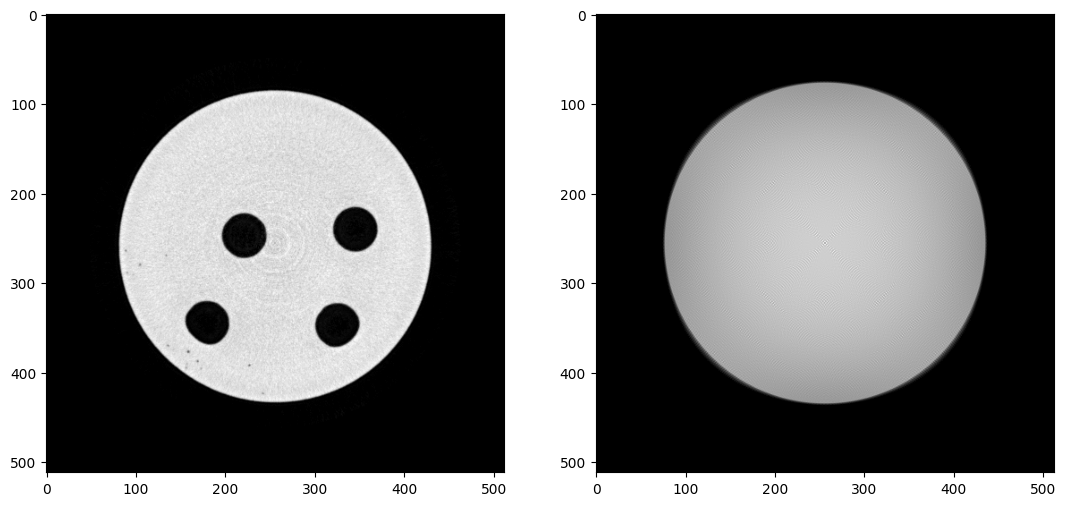

In [8]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1);plt.imshow(groundtruth,cmap='gray')
plt.subplot(1,2,2);plt.imshow(recon,cmap='gray')
plt.show()

x0 = np.ones(A.shape[1])*-50

1. (A,fsino.flatten(),50000,x0,beta=2,delta=5,regularizer='huber',iteration=25)
2. (A,fsino.flatten(),50000,x0,beta=2,delta=5,regularizer='gd',iteration=25)
3. GradientDescent.compute_GD(A,b,0.0001,x0,beta=5,regularizer='huber',iteration=50) // slightly better with tikhonov
4. GradientDescent.compute_GD(A,b,0.00001,x0,beta=5,regularizer='tikhonov',iteration=500) 
5. GradientDescent.compute_GD(A,b,0.000005,x0,beta=5,regularizer='tikhonov',iteration=1000) (best so far!! 0.9324)
6. GradientDescent.compute_GD(A,b,0.000005,x0,beta=2,delta=2,regularizer='fair',iteration=1000)

Withoug binning
1. GradientDescent.compute_OGM1(A,b,50000,x0,beta=10,delta=1,regularizer='huber',iteration=30) 0.8532584407446983


In [140]:
def apply_padding(image, pad_size):
    # Get the dimensions of the original image
    height, width = image.shape
   
    # Create a new array with the desired padding size
    padded_image = np.zeros((height, width + 2 * pad_size))
    print(padded_image.shape)

    # Copy the original image into the padded array
    padded_image[:, pad_size:-pad_size] = image
    
    return padded_image

[2023-05-21 23:50:26.674] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 280 poses in an 1000 degree arc


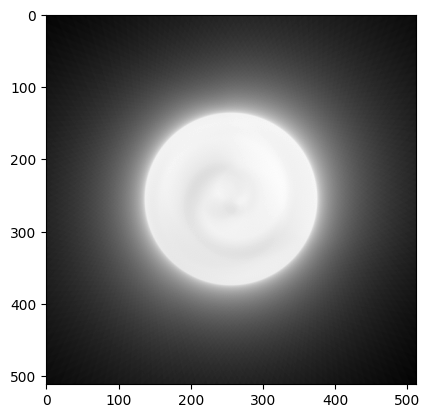

In [111]:
with open("config.json", "r") as json_data_file:
    data = json.load(json_data_file)
dataset = data["htc"]
data_path = (dataset["data_path"])["local"]
file_name = dataset["phantom2a"]

mat = loadmat(join(data_path,file_name))
data = mat['CtDataFull']
fullsino=data[0][0][1]
sino = bin_array(fullsino,2)
b=sino.flatten()

#b=fullsino.flatten()

size = np.array([512, 512])

num_angles = 360 #721
arc = 1000

s2c = size[0] * 20
c2d = size[0] * 0.1
D = s2c + c2d
A = aomip.XrayOperator(size, [num_angles], np.linspace(0, arc, 280), 1000,500)

###################### Filter ##############################################
# H = np.linspace(-1, 1, sino.shape[0])

# ram_lak = np.abs(H)
# shepp_logan = np.abs(H) * np.sinc(H / 2)
# cosine = np.abs(H) * np.cos(H * np.pi / 2)

# h = np.tile(shepp_logan, (280, 1)).T
# fftsino = np.fft.fft(sino, axis=0)
# projection = np.fft.fftshift(fftsino, axes=1) * np.fft.fftshift(h, axes=0)
# fsino = np.real(np.fft.ifft(np.fft.ifftshift(projection, axes=1), axis=0))
###################### Filter ##############################################
# b = fsino.flatten()
fbp_recon = A.applyAdjoint(sino)
plt.imshow(fbp_recon,cmap='gray')

final x:  [-0.24999975 -0.41686743  0.05127067 ... -0.43224243  0.01576832
 -0.28041765]
iteration OGM: 10


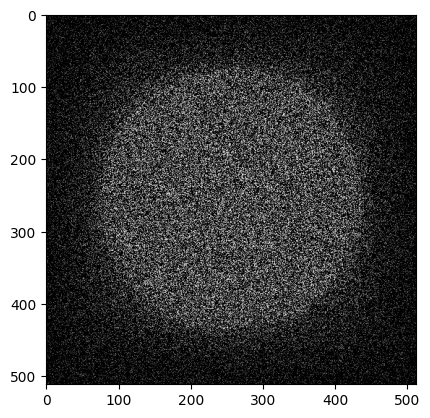

In [81]:
x0 = -np.random.rand(A.shape[1])

ogm_tik, iteration_OGM = GradientDescent.compute_OGM1(A,b,10000,x0,beta=1,delta=0,regularizer='tikhonov',iteration=10)
ogm_tik= ogm_tik.reshape((512,512))
ogm_tik[ogm_tik<0] = 0
print('iteration OGM:',iteration_OGM)
plt.imshow(ogm_tik,cmap='gray')
# save_array_as_image(ogm_tik,'OGM_tikhonov.png','img')
# imsave(join('img','1b_tikhonov.tif'), ogm_tik)

In [141]:
padde_sino = apply_padding(sino,20)

(360, 320)
